In [3]:
"""
STATISTICAL ANALYSIS OF QUECHUA MORPHOLOGY AND CORPUS
====================================================

This notebook performs statistical analysis on Quechua language data to understand:
1. Zipf's Law: Frequency distribution of morphological tokens
2. Heaps' Law: Vocabulary growth patterns in the corpus
3. Zipf-Mandelbrot fitting: Advanced frequency distribution modeling

These analyses help inform the morphology parser by understanding:
- How morphemes are distributed (Zipf)
- How vocabulary grows with corpus size (Heaps)
- Statistical properties that can be used as priors in parsing models

Data sources:
- Sue_kalt.parquet: Gold-standard morphological segmentations
- qu_merged_dump.txt: Large Quechua text corpus
"""

import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# =========================
# DATA FOLDER CONFIGURATION
# =========================
# All data files should be read from and saved to the data folder
DATA_FOLDER = "data"

In [4]:
# =========================
# PART 1: ZIPF'S LAW ANALYSIS ON MORPHOLOGICAL TOKENS
# =========================
# Load the Sue Kalt dataset which contains gold-standard morphological segmentations
# This dataset is used to analyze the frequency distribution of individual morphemes
# Zipf's law states that word/morpheme frequency is inversely proportional to rank

# Read the parquet file from the data folder
df = pd.read_parquet(os.path.join(DATA_FOLDER, "Sue_kalt.parquet"))

# Standardize column names and format morphological segmentation
df['Word'] = df['word']  # Original word form
df['morph'] = df['morph'].str.replace('-', ' ')  # Replace hyphens with spaces for consistency
df['Morph_split_str'] = df['morph']  # Keep string version
df['Morph_split'] = df['morph'].str.split(' ')  # Split into list of morphemes
df = df[['Word', 'Morph_split', 'Morph_split_str']]  # Keep only relevant columns

In [5]:
# Display first few rows to verify data loading
df.head()

,Word,Morph_split,Morph_split_str
0,cementerioman,"[cementerio, man]",cementerio man
1,kawsachkananta,"[kawsa, chka, na, n, ta]",kawsa chka na n ta
2,mañakunpis,"[maña, ku, n, pis]",maña ku n pis
3,imaynapichus,"[imayna, pi, chus]",imayna pi chus
4,qipiyuq,"[qipi, yuq]",qipi yuq


In [6]:
# Extract all individual morpheme tokens from all words
# This flattens the list of morpheme lists into a single list of all morphemes
# We filter out empty strings and non-string values
tokens = []
for toks in df["Morph_split"]:
    tokens.extend(t for t in toks if isinstance(t, str) and t.strip() != "")

In [7]:
# Count frequency of each morpheme token
# This gives us the distribution needed for Zipf's law analysis
freq = Counter(tokens)

In [8]:
# Sort frequencies in descending order for Zipf analysis
# Rank 1 = most frequent morpheme, Rank 2 = second most frequent, etc.
counts = np.array(sorted(freq.values(), reverse=True), dtype=np.int64)

Estimated Zipf exponent s (tail fit): 1.448


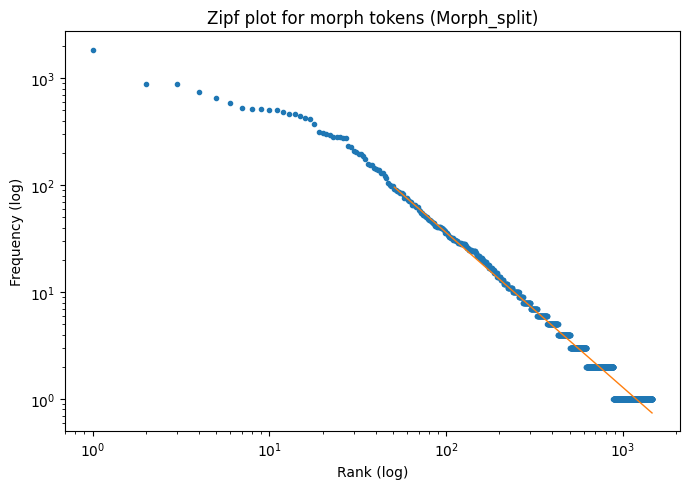

In [9]:
# =========================
# ZIPF'S LAW PLOT FOR MORPHEMES
# =========================
# Zipf's law: frequency ∝ rank^(-s), where s ≈ 1
# On a log-log plot, this appears as a straight line with slope ≈ -1
# This analysis helps understand morpheme distribution patterns

ranks = np.arange(1, len(counts) + 1, dtype=np.int64)

plt.figure(figsize=(7, 5))
plt.loglog(ranks, counts, marker='o', linestyle='none', markersize=3)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf plot for morph tokens (Morph_split)")

# --- Optional: quick line fit on the tail (exclude rank 1..k to reduce head bias) ---
# The head (most frequent tokens) often deviates from Zipf's law
# Fitting on the tail gives a better estimate of the true exponent
# Set k depending on your data size; 10–100 is often reasonable
k = min(50, len(counts) // 10 if len(counts) > 1000 else 10)
if len(counts) > k + 10:  # only fit if we have enough data
    x = np.log(ranks[k:])         # log rank
    y = np.log(counts[k:])        # log frequency
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    # Draw fitted line across the fitted portion
    plt.loglog(ranks[k:], np.exp(y_fit), linewidth=1)

    # Print an estimated Zipf exponent:
    # In a simple Zipf model: freq ~ C * rank^{-s}. On log-log, slope ≈ -s
    s_est = -slope
    print(f"Estimated Zipf exponent s (tail fit): {s_est:.3f}")

plt.tight_layout()
plt.show()

In [10]:
# =========================
# PART 2: CORPUS-LEVEL STATISTICAL ANALYSIS
# =========================
# Now we analyze the full Quechua text corpus (qu_merged_dump.txt)
# This is a large raw text file containing millions of tokens
# We'll analyze word-level statistics (not morpheme-level)

import os, re, math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIGURATION
# =========================
# File path: read from data folder
FILE_PATH = os.path.join(DATA_FOLDER, "qu_merged_dump.txt")

# Tokenization options
lowercase = True           # Convert all text to lowercase for consistent counting
keep_apostrophes = True    # Treat words with apostrophes (like runa'simi) as single tokens
                           # This is important for Quechua which uses apostrophes for glottal stops

# Analysis parameters (for later use)
tail_ignore = 50           # Ignore top-k ranks when fitting slope (to reduce head bias)
tail_min_len = 100         # Require at least this many points to fit

In [11]:
if keep_apostrophes:
    TOKEN_RE = re.compile(r"[^\W\d_]+(?:['’][^\W\d_]+)?", flags=re.UNICODE)
else:
    TOKEN_RE = re.compile(r"[^\W\d_]+", flags=re.UNICODE)

def iter_tokens_from_file(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if lowercase:
                line = line.lower()
            for m in TOKEN_RE.finditer(line):
                yield m.group(0)

In [12]:
# =========================
# COUNT TOKENS IN CORPUS
# =========================
# Process the entire corpus and count word frequencies
# This gives us the distribution needed for Zipf's law and Heaps' law analysis

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

# Count all tokens in the corpus
freq = Counter()
for tok in iter_tokens_from_file(FILE_PATH):
    freq[tok] += 1

# Calculate corpus statistics
total_tokens = sum(freq.values())  # Total number of word tokens
vocab_size   = len(freq)            # Number of unique word types

print(f"File: {FILE_PATH}")
print(f"Total tokens: {total_tokens:,}")
print(f"Vocabulary size: {vocab_size:,}")

# Display most frequent words (these are likely function words and common roots)
print("\nTop 25 tokens:")
for i, (tok, c) in enumerate(freq.most_common(25), 1):
    print(f"{i:>2}. {tok}\t{c}")

File: data\qu_merged_dump.txt
Total tokens: 2,053,877
Vocabulary size: 208,773

Top 25 tokens:
 1. mana	20920
 2. kay	20828
 3. chay	19580
 4. huk	19105
 5. nispa	16031
 6. diospa	14401
 7. nisqaqa	13149
 8. jehová	12300
 9. manan	11917
10. allin	10248
11. ichaqa	10122
12. mama	9935
13. llaqtapi	9566
14. hina	9294
15. ima	8440
16. chaymi	8351
17. karqan	8064
18. llaqta	7819
19. tukuy	7805
20. simipi	7597
21. ñiqin	7444
22. runa	6939
23. watapi	6923
24. killapi	6708
25. chayqa	6548


In [13]:
# Prepare data for Zipf plot: sort frequencies in descending order
# Rank 1 = most frequent word, Rank 2 = second most frequent, etc.
counts = np.array(sorted(freq.values(), reverse=True), dtype=np.int64)
ranks  = np.arange(1, len(counts) + 1, dtype=np.int64)

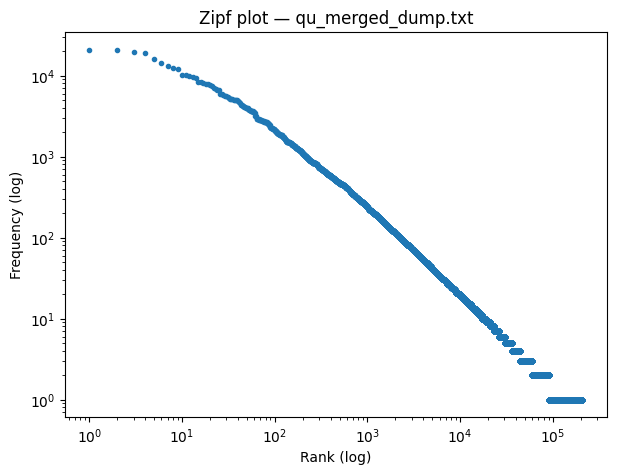

In [14]:
# =========================
# ZIPF'S LAW PLOT FOR CORPUS WORDS
# =========================
# Visualize the frequency-rank relationship for words in the corpus
# If Zipf's law holds, we should see a roughly straight line with slope ≈ -1

plt.figure(figsize=(7,5))
plt.loglog(ranks, counts, marker='o', linestyle='none', markersize=3)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf plot — " + os.path.basename(FILE_PATH))
plt.show()

In [15]:
# =========================
# PART 3: ADVANCED STATISTICAL MODELING
# =========================
# This section performs more sophisticated analyses:
# 1. Heaps' Law: Models vocabulary growth as corpus size increases
# 2. Zipf-Mandelbrot: More accurate model than simple Zipf's law
#    Formula: frequency = C / (rank + q)^s
#    The parameter 'q' accounts for deviations at low ranks

# =========================
# CONFIGURATION
# =========================
# File path: read from data folder
FILE_PATH = os.path.join(DATA_FOLDER, "qu_merged_dump.txt")

# Tokenization options
lowercase = True
keep_apostrophes = True  # Keep internal apostrophes in words like runa'simi

# Heaps' Law sampling parameters
# To avoid storing every single token, we sample vocabulary size at intervals
heaps_stride = 50        # Record vocab size every N tokens (10–200 is reasonable)
                         # Smaller stride = more accurate but slower

# Zipf–Mandelbrot fitting parameters
min_rank_for_fit = 1     # Starting rank for fit (often 10–100 to avoid head bias)
                         # Using 1 includes all ranks for full analysis
max_rank_for_fit = None  # Ending rank for fit (None = use all ranks)

In [16]:
# =========================
# Tokenizer
# =========================
if keep_apostrophes:
    TOKEN_RE = re.compile(r"[^\W\d_]+(?:['’][^\W\d_]+)?", flags=re.UNICODE)
else:
    TOKEN_RE = re.compile(r"[^\W\d_]+", flags=re.UNICODE)

def iter_tokens(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if lowercase:
                line = line.lower()
            for m in TOKEN_RE.finditer(line):
                yield m.group(0)

In [17]:
# =========================
# HEAPS' LAW: VOCABULARY GROWTH ANALYSIS
# =========================
# Heaps' Law states: V(n) ≈ K * n^β
# Where:
#   V(n) = vocabulary size after n tokens
#   K = constant
#   β = growth exponent (typically 0.4-0.6 for natural language)
# This helps predict vocabulary size as corpus grows

def vocab_growth(path, stride=50):
    """
    Track vocabulary growth as we process tokens from the corpus.
    Returns arrays of (token_count, vocabulary_size) pairs sampled at intervals.
    
    Args:
        path: Path to corpus file
        stride: Sample every N tokens (to save memory)
    
    Returns:
        n_points: Array of token counts where we sampled
        V_points: Array of vocabulary sizes at those points
    """
    seen = set()  # Track unique words seen so far
    n_points, V_points = [], []
    n = 0
    for tok in iter_tokens(path):
        n += 1
        if tok not in seen:
            seen.add(tok)
        # Sample vocabulary size at regular intervals
        if (n % stride) == 0:
            n_points.append(n)
            V_points.append(len(seen))
    # Ensure we capture the final point
    if not n_points or n_points[-1] != n:
        n_points.append(n)
        V_points.append(len(seen))
    return np.array(n_points, dtype=np.int64), np.array(V_points, dtype=np.int64)

def fit_heaps_logls(n, V, min_n=1000, tail_frac=0.7):
    """
    Fit Heaps' Law: V(n) = K * n^β
    We fit in log-space: log(V) = log(K) + β * log(n)
    
    Args:
        n: Array of token counts
        V: Array of vocabulary sizes
        min_n: Only fit on points with n >= min_n (to avoid early noise)
        tail_frac: Only use the last fraction of points (e.g., 0.7 = last 70%)
    
    Returns:
        beta: Growth exponent (slope in log-log space)
        K: Constant term
        r2: R-squared goodness of fit
        (n0, n1): Range of n values used in fit
    """
    # Filter to points with sufficient tokens
    mask = n >= max(1, min_n)
    n_fit, V_fit = (n[mask], V[mask]) if mask.any() else (n, V)

    # Use only tail fraction to focus on asymptotic behavior
    if 0 < tail_frac < 1.0:
        start = int((1 - tail_frac) * len(n_fit))
        n_fit = n_fit[start:]
        V_fit = V_fit[start:]

    # Fit linear regression in log-log space
    x = np.log(n_fit)
    y = np.log(V_fit)
    slope, intercept = np.polyfit(x, y, 1)
    beta = slope  # This is the Heaps exponent
    K = np.exp(intercept)  # Constant term
    
    # Calculate R-squared for goodness of fit
    yhat = slope * x + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return beta, K, r2, (n_fit[0], n_fit[-1])

# =========================
# ZIPF-MANDELBROT FITTING
# =========================
# Zipf-Mandelbrot is a refinement of Zipf's law:
#   frequency(r) = C / (r + q)^s
# Where:
#   r = rank
#   C = normalization constant
#   s = exponent (similar to Zipf's s)
#   q = parameter that accounts for deviations at low ranks

def counts_from_file(path):
    """
    Count word frequencies in the corpus and return sorted counts.
    
    Returns:
        counts: Array of frequencies sorted in descending order
        freq: Counter object with all word frequencies
    """
    freq = Counter()
    for tok in iter_tokens(path):
        freq[tok] += 1
    counts = np.array(sorted(freq.values(), reverse=True), dtype=np.int64)
    return counts, freq

def fit_zipf_mandelbrot(counts, rmin=1, rmax=None):
    """
    Fit Zipf-Mandelbrot model: frequency(r) = C / (r + q)^s
    
    The fitting is done in log-space to minimize RMSE:
        log(frequency) = log(C) - s * log(r + q)
    
    Uses a two-stage approach:
    1. Coarse grid search over s and q
    2. Refined local search around best parameters
    
    Args:
        counts: Array of frequencies sorted by rank (descending)
        rmin: Minimum rank to include in fit
        rmax: Maximum rank to include in fit (None = all)
    
    Returns:
        s: Exponent parameter
        q: Shift parameter
        C: Normalization constant
        rmse_log: Root mean squared error in log-space
        (rmin, rmax): Rank range used for fitting
    """
    R = np.arange(1, len(counts) + 1, dtype=np.float64)
    if rmax is None or rmax > len(R): rmax = len(R)
    r_slice = slice(rmin-1, rmax)
    r = R[r_slice]
    c = counts[r_slice].astype(np.float64)

    log_r = np.log(r)

    def rmse_for(s, q):
        """Calculate RMSE for given s and q parameters."""
        # Avoid invalid (r+q)<=0
        rq = r + q
        if np.any(rq <= 0):
            return np.inf, None
        log_rq = np.log(rq)
        # Optimal C in log space (closed form solution)
        logC = np.mean(np.log(c) + s * log_rq)
        # Predicted log frequencies
        logc_hat = logC - s * log_rq
        rmse = np.sqrt(np.mean((np.log(c) - logc_hat)**2))
        return rmse, logC

    # --- Stage 1: Coarse grid search ---
    s_grid = np.linspace(0.6, 1.6, 27)  # Typical range for natural language
    # Sensible q range: small values for most corpora, up to a few hundred
    q_grid = np.concatenate([np.linspace(0.0, 20.0, 21),
                             np.linspace(25.0, 200.0, 8)])
    best = (np.inf, None, None, None)  # (rmse, s, q, logC)
    for s in s_grid:
        for q in q_grid:
            rmse, logC = rmse_for(s, q)
            if rmse < best[0]:
                best = (rmse, s, q, logC)

    rmse0, s0, q0, logC0 = best

    # --- Stage 2: Refined local search around best parameters ---
    def refine(s_c, q_c, s_step=0.05, q_step=2.0, n_iter=6):
        """Refine parameters using iterative local search."""
        best_rmse, best_s, best_q, best_logC = rmse0, s0, q0, logC0
        for _ in range(n_iter):
            improved = False
            # Search in neighborhood around current best
            for s in np.linspace(best_s - s_step, best_s + s_step, 7):
                for q in np.linspace(max(-0.9, best_q - q_step), best_q + q_step, 7):
                    rmse, logC = rmse_for(s, q)
                    if rmse < best_rmse:
                        best_rmse, best_s, best_q, best_logC = rmse, s, q, logC
                        improved = True
            # Narrow search window if no improvement
            s_step *= 0.5
            q_step *= 0.5
            if not improved:
                break
        return best_rmse, best_s, best_q, best_logC

    rmse, s, q, logC = refine(s0, q0)
    C = float(np.exp(logC))
    return s, q, C, rmse, (rmin, rmax)

In [18]:
# =========================
# EXECUTE HEAPS' LAW ANALYSIS
# =========================
# This section calculates Heaps' Law parameters for the Quechua corpus
# These parameters can be used to predict vocabulary growth and inform parser design

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

# Track vocabulary growth as we process the corpus
n_arr, V_arr = vocab_growth(FILE_PATH, stride=heaps_stride)

# Fit Heaps' Law: V(n) = K * n^β
# Using min_n=2000 to skip early noisy points, tail_frac=0.7 to focus on asymptotic behavior
beta, K, r2, (n0, n1) = fit_heaps_logls(n_arr, V_arr, min_n=2000, tail_frac=0.7)

print("\n=== Heaps' Law ===")
print(f"β (slope): {beta:.4f}")  # Growth exponent (typically 0.4-0.6 for natural language)
print(f"K: {K:.4f}")              # Constant term
print(f"R^2 (log–log fit): {r2:.4f}")  # Goodness of fit (1.0 = perfect)
print(f"Fit range n in [{n0}, {n1}]   total tokens seen ~ {n_arr[-1]}   vocab ~ {V_arr[-1]}")


=== Heaps' Law ===
β (slope): 0.9008
K: 0.4279
R^2 (log–log fit): 0.9804
Fit range n in [617550, 2053877]   total tokens seen ~ 2053877   vocab ~ 208773


In [19]:
# =========================
# EXECUTE ZIPF-MANDELBROT FITTING
# =========================
# Fit the Zipf-Mandelbrot model to the word frequency distribution
# This provides more accurate frequency predictions than simple Zipf's law
# The parameters can be used as priors in morphology parsing models

# Get word frequency counts from corpus
counts, freq = counts_from_file(FILE_PATH)
ranks = np.arange(1, len(counts)+1, dtype=np.int64)

# Fit Zipf-Mandelbrot model: frequency(r) = C / (r + q)^s
rmin = max(1, min_rank_for_fit)
rmax = len(counts) if max_rank_for_fit is None else min(max_rank_for_fit, len(counts))
s, q, C, rmse_log, (rf0, rf1) = fit_zipf_mandelbrot(counts, rmin=rmin, rmax=rmax)

print("\n=== Zipf–Mandelbrot ===")
print(f"s: {s:.4f}")              # Exponent (similar to Zipf's s, typically ~1)
print(f"q: {q:.4f}")              # Shift parameter (accounts for low-rank deviations)
print(f"C: {C:.4e}")              # Normalization constant
print(f"RMSE in log-frequency (fit ranks [{rf0}, {rf1}]): {rmse_log:.4f}")  # Fit quality



=== Zipf–Mandelbrot ===
s: 1.0615
q: 7.0000
C: 3.0705e+05
RMSE in log-frequency (fit ranks [1, 208773]): 0.2014


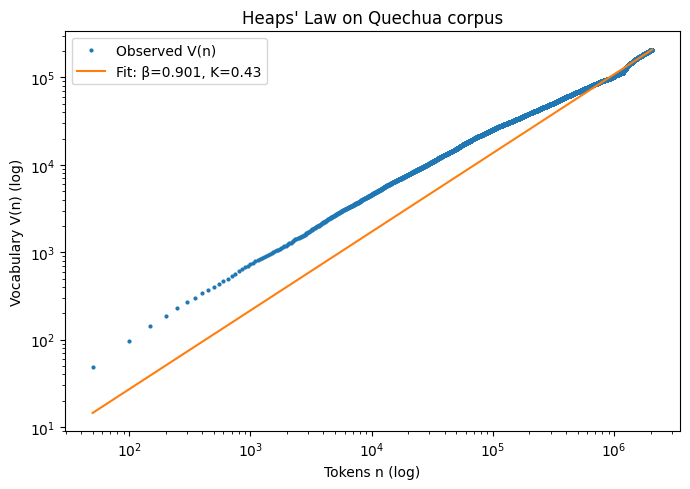

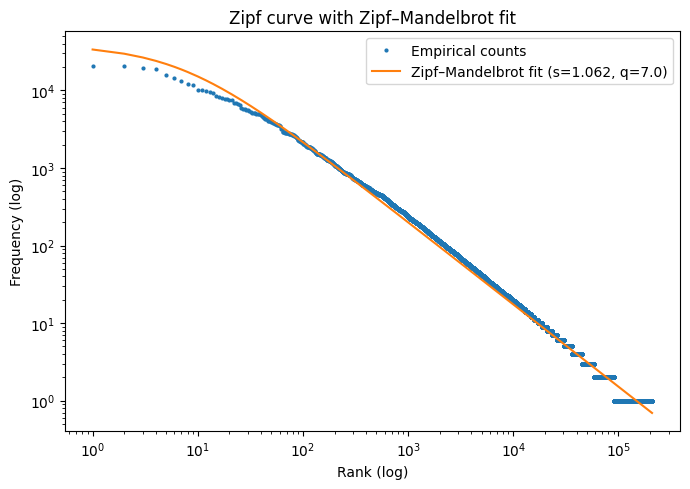

In [20]:
# =========================
# VISUALIZATION: PLOTS
# =========================
# Create visualizations to verify the statistical models fit the data well

# 1) Heaps' Law plot: vocabulary growth over time
plt.figure(figsize=(7,5))
plt.loglog(n_arr, V_arr, marker='o', linestyle='none', markersize=2, label="Observed V(n)")
# Overlay the fitted Heaps' Law curve
V_fit = K * (n_arr.astype(float) ** beta)
plt.loglog(n_arr, V_fit, linewidth=1.5, label=f"Fit: β={beta:.3f}, K={K:.2f}")
plt.xlabel("Tokens n (log)")
plt.ylabel("Vocabulary V(n) (log)")
plt.title("Heaps' Law on Quechua corpus")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Zipf curve with Zipf–Mandelbrot model overlay
plt.figure(figsize=(7,5))
plt.loglog(ranks, counts, marker='o', linestyle='none', markersize=2, label="Empirical counts")
# Overlay the fitted Zipf-Mandelbrot model curve
r = ranks.astype(float)
model = C / ((r + q) ** s)
plt.loglog(r, model, linewidth=1.5, label=f"Zipf–Mandelbrot fit (s={s:.3f}, q={q:.1f})")
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf curve with Zipf–Mandelbrot fit")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# =========================
# ROLLING HEAPS EXPONENT ANALYSIS
# =========================
# Calculate the Heaps exponent (β) using a rolling window
# This shows how the growth rate changes as the corpus grows
# A decreasing β suggests vocabulary growth is slowing (expected for large corpora)

import numpy as np

win = 200  # Window size for rolling slope calculation
           # Adjust based on your heaps_stride (should be ~4-10x stride)

# Convert to log-space for linear regression
x = np.log(n_arr.astype(float))
y = np.log(V_arr.astype(float))

# Calculate rolling β (slope) over windows
roll_beta = np.full_like(x, np.nan, dtype=float)
for i in range(win, len(x)):
    xs, ys = x[i-win:i], y[i-win:i]
    slope, _ = np.polyfit(xs, ys, 1)
    roll_beta[i] = slope

# Display the tail values to see asymptotic behavior
print("Tail rolling β (last 5):", np.round(roll_beta[-5:], 3))
# Note: β typically decreases as corpus grows (vocabulary growth slows)


Tail rolling β (last 5): [0.624 0.621 0.619 0.618 0.616]


In [22]:
# =========================
# OPTIONAL: SAVE RESULTS TO DATA FOLDER
# =========================
# Uncomment the following code to save analysis results for later use

# Save Heaps' Law parameters
# heaps_results = {
#     'beta': float(beta),
#     'K': float(K),
#     'r2': float(r2),
#     'total_tokens': int(n_arr[-1]),
#     'vocab_size': int(V_arr[-1])
# }
# import json
# with open(os.path.join(DATA_FOLDER, 'heaps_law_results.json'), 'w') as f:
#     json.dump(heaps_results, f, indent=2)

# Save Zipf-Mandelbrot parameters
# zipf_mandelbrot_results = {
#     's': float(s),
#     'q': float(q),
#     'C': float(C),
#     'rmse_log': float(rmse_log),
#     'rank_range': [int(rf0), int(rf1)]
# }
# with open(os.path.join(DATA_FOLDER, 'zipf_mandelbrot_results.json'), 'w') as f:
#     json.dump(zipf_mandelbrot_results, f, indent=2)

# Save vocabulary growth data
# vocab_growth_df = pd.DataFrame({
#     'token_count': n_arr,
#     'vocab_size': V_arr
# })
# vocab_growth_df.to_csv(os.path.join(DATA_FOLDER, 'vocab_growth_heaps.csv'), index=False)

# Save word frequency distribution
# freq_df = pd.DataFrame({
#     'word': list(freq.keys()),
#     'frequency': list(freq.values())
# })
# freq_df = freq_df.sort_values('frequency', ascending=False)
# freq_df.to_csv(os.path.join(DATA_FOLDER, 'word_frequencies.csv'), index=False)
